## In this script, we will try to train a simple autoencoder model, that we hope it could duplicate the input data.
## In section 1, we trained a very simple autoencoder, it has 4 layers in encoder and decoder. The result it should was good, but not good enough. It gives very blurred image, which is quite different from our input

## Next section, we tried to use a method called skip-connection. It is a method to keep more patterns in original data in the outputs.

Step 1:
we would need to import all the libraries we need. One thing noticable is that we will be using tensorflow as the foundation of our autoencoder. Unlike normal python libraries, tensorflow reuqire to be installed in a venv. So the very first step should be build a tensorflow venv and then config it. Using anaconda, you can easily do so by a few lines of code.

In [145]:
# Import libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

Step 2: we load in our raw data. It is stored in a .npy file, which is a numpy array.

In [168]:
arr = np.load('new_arr.npy')

Then we take a look at the arr shape, because later we will be using this to config our encoders.

In [169]:
arr.shape

(904, 1744)

Step 3: We do some data wrangling. The most important thing we do here is to make the range of data to (0,1) which yields a greyscale plot. Usually encoders works the best on greyscale data.

In the reshape part, we have the shape of the data set as following [1,m,n,k]. Where 1 is a index that used in the encoder,it does not affect the final result at all. m,n are the dimension of each individual image. k is the total number of the images we contain in training set, in our case, k is equal to 1 by default.

In [ ]:
# reshape

x_train=np.reshape(arr,(arr.shape[0],arr.shape[1],1))
x_test=np.reshape(arr,(arr.shape[0],arr.shape[1],1))

In [ ]:
# change to 0,1 greyscale
x_train = (x_train - np.nanmin(x_train)) / (np.nanmax(x_train) - np.nanmin(x_train))
x_test = (x_test - np.nanmin(x_test)) / (np.nanmax(x_test) - np.nanmin(x_test))

We do slight cut in the dataset so that the shape of the data is divisible by 8.

In [ ]:
# remove nan
x_train = np.nan_to_num(x_train, nan=0)
x_test = np.nan_to_num(x_test, nan=0)

x_train = np.reshape(x_train, (1, 904, 1744, 1))

x_train=x_train[1,4:,4:,1]

Step 4: In the next cell, we will define our autoencoder. We do so by first define a encoder and a decoder. For the loss function, we consider using the mse, which is mean square error.

## Encoder Definition
The encoder part of the autoencoder is defined as below. This uses convolutional layers (Conv2D) for spatial data processing, interspersed with max-pooling layers (MaxPooling2D) for down-sampling. The Conv2D layer parameters are:

Number of filters
Kernel size
Activation function
Padding strategy
The number of filters, which also represents the depth of output space, increases after each max-pooling operation. 'Relu' is used as the activation function, and 'same' padding ensures the output has the same height/width dimensions as the input.

The encoding process reduces the dimensionality of the input data and compresses it into an encoded representation.

## Activation Functions
Activation functions introduce non-linearity into the output of a neuron. This allows the model to learn more complex patterns. Here are a few commonly used activation functions:

ReLU (Rectified Linear Unit): It returns 0 if the input is less than 0, and for any positive input, it returns the value itself. Due to its simplicity and effectiveness, especially in deeper networks, ReLU is often the first choice.

Sigmoid: The sigmoid function maps any input value into a range between 0 and 1, which makes it useful for outputting probabilities. However, it can suffer from vanishing gradient problems, which can slow down training.

Tanh: The tanh function maps any input value into a range between -1 and 1. Like the sigmoid function, it can also suffer from vanishing gradients.

Softmax: This function is often used in the output layer of a classifier where we're trying to assign the input to one of multiple classes. It converts the raw output into probabilities, with the sum of all probabilities equal to 1.

## Decoder Definition
The decoder, similar to the encoder, uses Conv2D layers but uses up-sampling layers (UpSampling2D) to increase the spatial resolution of the output. The final layer is a Conv2D layer with a 'sigmoid' activation function to reconstruct the original input.

## Model Definition
The autoencoder model is defined by specifying the input tensor and the output tensor (the decoded image). It is then compiled with the 'Adam' optimizer and mean squared error (mse) as the loss function, which suits the reconstruction nature of the autoencoder task.

## Optimizers
Optimizers are algorithms used to adjust the attributes of the neural network, such as the weights and learning rate, to minimize the loss function. Some common optimizers include:

Stochastic Gradient Descent (SGD): This is a simple yet very efficient approach to fitting linear classifiers and regressors under convex loss functions such as (linear) Support Vector Machines and Logistic Regression.

Adam: Adam, short for Adaptive Moment Estimation, is a modification of SGD. It uses different learning rates for different parameters and adjusts them as training progresses. This makes it a popular choice for deep learning tasks.

RMSprop: The RMSprop optimizer is similar to the gradient descent algorithm with momentum. It adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate.

Adagrad: Adagrad allows the learning Rate to adapt based on parameters. It performs smaller updates (low learning rates) for parameters associated with frequently occurring features, and larger updates (high learning rates) for parameters associated with infrequent features.

In [148]:
# Version 1

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

input_img = Input(shape=(900, 1740, 1))  # Adjusting input size

# Define encoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Define decoder
x = Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Define model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(x_train, x_train,
                epochs=30,
                batch_size=250,
                shuffle=True)




Step 5: We will make a plot to make comparison between our original data and the predicted data.

In [ ]:
import matplotlib.pyplot as plt

# Use the trained autoencoder to generate the output from the input
decoded_imgs = autoencoder.predict(x_train)

n = 1  # Number of images to display
plt.figure(figsize=(20, 8))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_train[i].reshape(900, 1740),cmap='gray')
    plt.title('Original')
    plt.colorbar()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(900, 1740),cmap='gray')
    plt.title('Predicted')
    plt.colorbar()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We also take a look at the mse to see how our model performed.

In [ ]:

mse = np.mean(np.power(x_train - decoded_imgs, 2), axis=(1,2,3))
print('Reconstruction error:', np.mean(mse))


Step 5:
As we noticed, the predicted data plot is not quite good. It has a low resolution, and missing the details. We should take a look at the data by comparing the histogram and periodogram between them.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

array1 = x_train
array2 = decoded_imgs

# Calculate the histograms
hist1, bins = np.histogram(array1, bins=50, range=(0, 1))
hist2, _ = np.histogram(array2, bins=bins)

total_elements1 = np.prod(array1.shape)
total_elements2 = np.prod(array2.shape)
hist1_norm = hist1 / total_elements1
hist2_norm = hist2 / total_elements2

# Plot the histograms
plt.figure(figsize=(10, 6))
plt.hist(bins[:-1], bins, weights=hist1_norm, alpha=0.5, label='Original Data')
plt.hist(bins[:-1], bins, weights=hist2_norm, alpha=0.5, label='Predicted Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Frequency Comparison')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

array1 = x_train
array2 = decoded_imgs

array1 = array1.reshape(-1)
array2 = array2.reshape(-1)

# Create plot
plt.figure(figsize=(10, 5))

# Compute and plot PSD for both arrays
plt.psd(array1, NFFT=1024, label='Original Data')
plt.psd(array2, NFFT=1024, label='Predicted Data')

plt.title('Periodogram')
plt.xlabel('Frequency')
plt.ylabel('Power Spectrum Density')
plt.legend()
plt.grid(True)
plt.show()





## Next we try new method.

In the next part, we will try update our method by adding some tricks to the autoencoder.

The data wrangling part is basically the same, but one thing different is that in the new autoencoder, we add more layers which make the reuqirement for the dismension changed. It now requires a dimension divisible by 4 not 8. So we can skip the part where we cut the data.

In [ ]:
# reshape

x_train=np.reshape(arr,(arr.shape[0],arr.shape[1],1))
x_test=np.reshape(arr,(arr.shape[0],arr.shape[1],1))


# change to 0,1 greyscale
x_train = (x_train - np.nanmin(x_train)) / (np.nanmax(x_train) - np.nanmin(x_train))
x_test = (x_test - np.nanmin(x_test)) / (np.nanmax(x_test) - np.nanmin(x_test))


# remove nan
x_train = np.nan_to_num(x_train, nan=0)
x_test = np.nan_to_num(x_test, nan=0)

x_train = np.reshape(x_train, (1, 904, 1744, 1))

# x_train=x_train[1,4:,4:,1]

Skip-connection is a trick that we want to capture more details in our predicted data. Basically, in each step of decoding, we add the corresponding layer from encoder, to make a combination of decoded data and encoded data.

The Input function defines an input image of shape (904, 1744, 1), where 904 and 1744 are the height and width of the image, and 1 represents a single channel (grayscale).

## Skip Connections
In a neural network, layers are connected sequentially, meaning each layer's output is the input to the next layer. However, in deep networks, this can lead to a well-known problem called the vanishing gradient, where the gradients of the loss function become very small. As a result, the weights of the network are updated very little, and the network stops learning.

Skip connections are a solution to this problem. They allow the gradient to be back-propagated to earlier layers, providing an unimpeded, direct path from later layers to initial ones. The main idea is to bypass (or "skip") one or more layers and feed the output from one layer into a later layer.

Skip connections were popularized by the ResNet (Residual Network) architecture, which uses them to train very deep networks (even over 1000 layers). The major benefit of skip connections is that they allow the network to learn identity functions, which makes the optimization of the loss landscape easier.

In [151]:

# Skip Connection Version

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

input_img = Input(shape=(904, 1744, 1))  # Adjusting input size


## Introduction to Skip Connections in U-Net Autoencoder
In this code, we're implementing a U-Net autoencoder, a type of neural network architecture commonly used in image segmentation tasks. One key characteristic of the U-Net architecture is the use of skip connections, which provide a shortcut from earlier layers to later ones. Skip connections allow the model to use local, detailed features from earlier in the network alongside more global, abstract features from deeper in the network, greatly enhancing its performance in tasks like image segmentation.

Here's a breakdown of how the skip connections are implemented in the code:

## Encoder (Downsampling)
The first part of the U-Net is the encoder, which gradually reduces the spatial dimensions of the input image while increasing the depth of the feature maps:

In [ ]:

# Define encoder
x1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x1)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x2)
x3 = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x3)


In the above section, the script performs convolution operations ('Conv2D') followed by downsampling operations ('MaxPooling2D'). The outputs of each convolution operation (stored as 'x1', 'x2', 'x3') represent the learned feature maps at each layer.

In [ ]:

# Define decoder
x = Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
x = concatenate([x3, x])
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
x = concatenate([x2, x])
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
x = concatenate([x1, x])
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


Here, each upsampling operation ('Conv2DTranspose') is followed by a concatenation ('concatenate'). This is where the skip connections come in. The concatenate operation combines the feature map from the corresponding downsampling step ('x3', 'x2', 'x1') with the upsampled output. By doing so, the decoder part of the network receives information about the original, pre-downsampled image, which allows it to better recreate the details in the final output, decoded.

These skip connections enable the network to produce more precise reconstructions, making the U-Net architecture particularly effective for image segmentation or other tasks where the preservation of spatial relationships is important.

In [ ]:

# Define model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')


autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=250,
                shuffle=True)




After our model, we want now to print out the results again, to see if there's any improvements. And we can certainly notice that the result is much better under this method.

1/1 [==============================] - 6s 6s/step


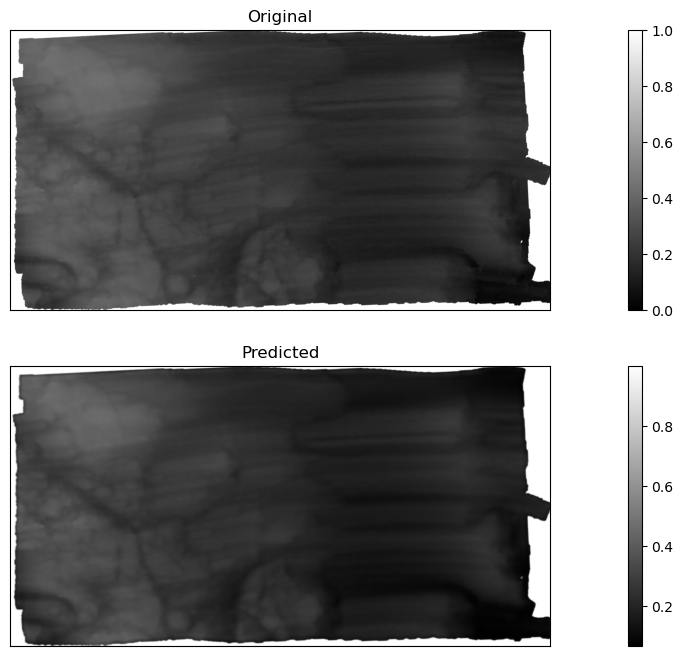

In [161]:
import matplotlib.pyplot as plt

# Use the trained autoencoder to generate the output from the input
decoded_imgs = autoencoder.predict(x_train)

n = 1  # Number of images to display
plt.figure(figsize=(20, 8))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_train[i].reshape(904, 1744),cmap='gray')
    plt.title('Original')
    plt.colorbar()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(904, 1744),cmap='gray')
    plt.title('Predicted')
    plt.colorbar()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


Keep an eye on the mse, we can still observe really low mse.

In [158]:
# Assuming X_test is our test data
mse = np.mean(np.power(x_train - decoded_imgs, 2), axis=(1,2,3))
print('Reconstruction error:', np.mean(mse))


Reconstruction error: 0.00045130044


To further visualize the improvement of this new method, we still use the histogram and periodogram. We can find out that in histogram, the new method behave better and in the periodogram, we still observe loss in high frequency. Whether this should be a problem to us is till pending experiment, but we do have improved the quality of the predicted data and thus it could be used in our further steps.

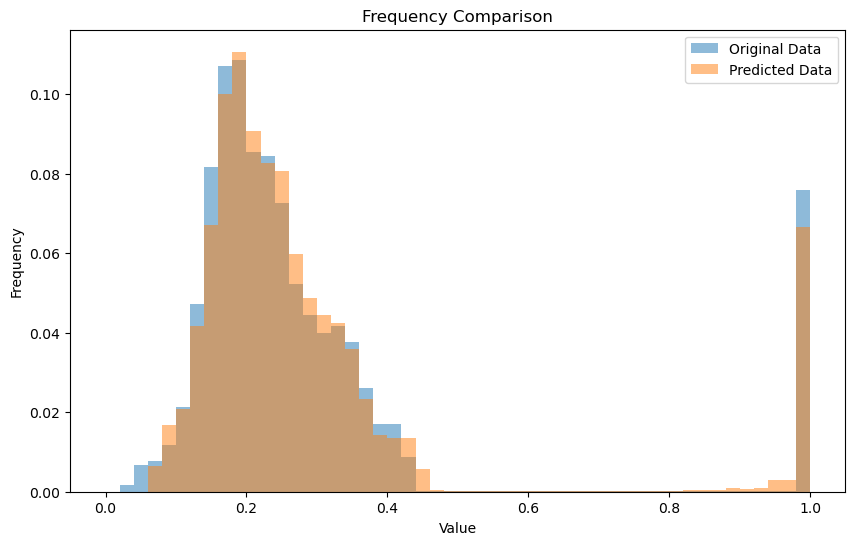

In [162]:
import numpy as np
import matplotlib.pyplot as plt

array1 = x_train
array2 = decoded_imgs

# Calculate the histograms
hist1, bins = np.histogram(array1, bins=50, range=(0, 1))
hist2, _ = np.histogram(array2, bins=bins)

total_elements1 = np.prod(array1.shape)
total_elements2 = np.prod(array2.shape)
hist1_norm = hist1 / total_elements1
hist2_norm = hist2 / total_elements2

# Plot the histograms
plt.figure(figsize=(10, 6))
plt.hist(bins[:-1], bins, weights=hist1_norm, alpha=0.5, label='Original Data')
plt.hist(bins[:-1], bins, weights=hist2_norm, alpha=0.5, label='Predicted Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Frequency Comparison')
plt.legend()
plt.show()


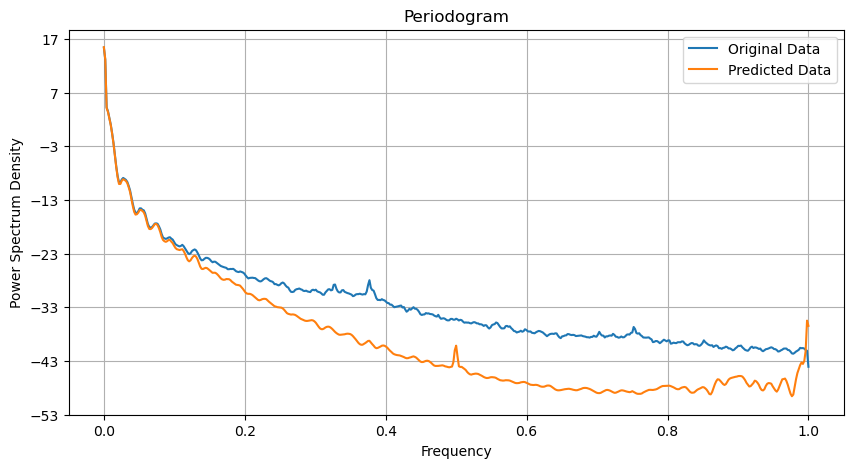

In [163]:
import numpy as np
import matplotlib.pyplot as plt

array1 = x_train
array2 = decoded_imgs

array1 = array1.reshape(-1)
array2 = array2.reshape(-1)

# Create plot
plt.figure(figsize=(10, 5))

# Compute and plot PSD for both arrays
plt.psd(array1, NFFT=1024, label='Original Data')
plt.psd(array2, NFFT=1024, label='Predicted Data')

plt.title('Periodogram')
plt.xlabel('Frequency')
plt.ylabel('Power Spectrum Density')
plt.legend()
plt.grid(True)
plt.show()





## Conclusion
Based on the code and comparison of the two methods, it can be concluded that the autoencoder with skip connections (Method 2) outperforms the regular autoencoder (Method 1) in terms of producing a more accurate reconstructed image with higher resolution and detail.

This superior performance can be attributed to the concept of skip connections, which allows for the transfer of detailed information from the encoder to the decoder. This improves the flow of information through the network and reduces the risk of information loss during encoding. Skip connections essentially enable the network to retain and leverage the fine-grained details that are otherwise lost in the encoding process, hence resulting in a higher resolution and more detailed output.

On the other hand, the regular autoencoder, lacking skip connections, may lose valuable information during the encoding process, which leads to a lower-quality reconstruction of the input. While the regular autoencoder can learn a compact and effective representation of the input data, the lack of direct pathways means that some details may be lost during encoding, hence it may fail to perfectly reconstruct certain intricate aspects of the input data.

In conclusion, Method 2 effectively addresses one of the primary limitations of the regular autoencoder architecture (Method 1) and demonstrates an improvement in image reconstruction quality.